## 代码实现

接下来让我们动手学习 Lucas-Kanade 算法。首先，我们制造一张噪音图像并将其顺时针旋转1度。

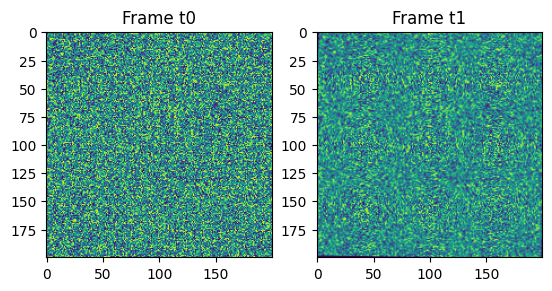

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import math

# 根据角度旋转图像
def rotate_image(img, angle):
    # 计算旋转中心
    center = tuple(np.array(img.shape[1::-1]) / 2)
    # 计算旋转矩阵
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    # 旋转图像
    rotated = cv2.warpAffine(img, rot_mat, 
                    img.shape[1::-1], flags=cv2.INTER_LINEAR)
    return rotated

# 创建一个200*200的随机数组，并将其转换为float32类型
img_t0 = np.random.rand(200, 200).astype(np.float32)

# 复制img_t0的内容到img_t1
img_t1 = img_t0.copy()

# 将img_t1旋转-1度
img_t1 = rotate_image(img_t1, -1)

# 可视化
fig1, (ax_1, ax_2) = plt.subplots(1, 2)
# 在ax_1中显示img_t0
ax_1.imshow(img_t0)
ax_1.set_title("Frame t0")
# 在ax_2中显示img_t1
ax_2.imshow(img_t1)
ax_2.set_title("Frame t1")
# 显示图像
plt.show()

接着，我们实现一个高斯滤波器对图像进行平滑处理以降低噪声影响，然后计算图像的梯度。

In [2]:
def smooth(img, sigma):
    """
    高斯平滑函数，返回平滑后的图像。

    参数:
    - img: 输入图像。
    - sigma: 高斯核的标准差。
    """
    # 创建x数组，范围为[-3sigma,3sigma]
    x = np.array(list(range(math.floor(-3.0 * sigma + 0.5), 
                            math.floor(3.0 * sigma + 0.5) + 1)))
    
    # 计算高斯核G
    G = np.exp(-x ** 2 / (2 * sigma ** 2))
    G = G / np.sum(G)

    # 对图像进行二维卷积
    return cv2.sepFilter2D(img, -1, G, G)


def gaussderiv(img, sigma):
    """
    高斯求导函数。

    参数:
    - param img: 输入图像。
    - param sigma: 高斯核的标准差。

    返回:
    - Dx: x轴方向的导数图像。
    - Dy: y轴方向的导数图像。
    """
    # 创建x数组，范围为[-3sigma,3sigma]
    x = np.array(list(range(math.floor(-3.0 * sigma + 0.5), 
                            math.floor(3.0 * sigma + 0.5) + 1)))

    # 计算高斯核G
    G = np.exp(-x ** 2 / (2 * sigma ** 2))
    G = G / np.sum(G)

    # 计算高斯求导核D
    D = -2 * (x * np.exp(-x ** 2 / (2 * sigma ** 2))) / ( \
                            np.sqrt(2 * math.pi) * sigma ** 3)
    D = D / (np.sum(np.abs(D)) / 2)

    # 分别对图像进行x方向和y方向二维卷积
    Dx = cv2.sepFilter2D(img, -1, D, G)
    Dy = cv2.sepFilter2D(img, -1, G, D)

    return Dx, Dy

def calculate_derivatives(img1, img2, smoothing, derivation):
    """
    计算图像的导数。

    参数:
    - img1: 前一帧图像。
    - img2: 后一帧图像。
    - smoothing: 高斯平滑的标准差。
    - derivation: 高斯求导的标准差。

    返回:
    - i_x: x轴方向的导数图像。
    - i_y: y轴方向的导数图像。
    - i_t: 时间方向的导数图像。
    """
    # 计算t方向导数
    i_t = smooth(img2 - img1, smoothing)
    # 计算x、y方向导数
    i_x, i_y = gaussderiv(smooth(np.divide(img1 + \
                                img2, 2), smoothing), derivation)
    return i_x, i_y, i_t

再根据得到的梯度分块计算区块内的光流。

In [3]:
def sum_kernel(x, N):
    '''
    计算块内和。
    '''
    return cv2.filter2D(x, -1, np.ones((N, N)))

def lucas_kanade(img1, img2, N, smoothing=1, derivation=0.4):
    """
    Lucas-Kanade算法。

    参数:
    - img1: 前一帧图像。
    - img2: 后一帧图像。
    - N: 块大小。
    - smoothing: 高斯平滑的标准差。
    - derivation: 高斯求导的标准差。

    返回:
    - u: x轴方向的速度图像。
    - v: y轴方向的速度图像。
    """
    # 计算图像导数
    i_x, i_y, i_t = calculate_derivatives(img1, img2, 
                              smoothing, derivation)
    
    # 计算i_x_t和i_y_t
    i_x_t = sum_kernel(np.multiply(i_x, i_t), N)
    i_y_t = sum_kernel(np.multiply(i_y, i_t), N)
    
    # 计算梯度的平方
    i_x_2 = sum_kernel(np.square(i_x), N)
    i_y_2 = sum_kernel(np.square(i_y), N)
    
    i_x_y = sum_kernel(np.multiply(i_x, i_y), N)
    
    # 计算平方和
    D = np.subtract(
        np.multiply(i_x_2, i_y_2),
        np.square(i_x_y)
    )

    D += 1e-5
    
    # 计算各块内的u, v
    u = np.divide(
        np.add(
            np.multiply(-i_y_2, i_x_t),
            np.multiply(i_x_y, i_y_t)
        ),
        D
    )

    v = np.divide(
        np.subtract(
            np.multiply(i_x_y, i_x_t),
            np.multiply(i_x_2, i_y_t)
        ),
        D
    )

    return u, v

至此，我们已经得到两张图像间的运动向量，接下来我们将其可视化出来。

In [4]:
def show_flow(U, V, ax):
    """
    根据提供的U,V绘制光流。
    """
    # 控制分块的大小
    scaling = 0.1 
    # 使用高斯平滑处理光流
    u = cv2.resize(smooth(U, 1.5), (0, 0), 
                           fx=scaling, fy=scaling)
    v = cv2.resize(smooth(V, 1.5), (0, 0), 
                           fx=scaling, fy=scaling)

    # 生成x,y的坐标矩阵
    x_ = (np.array(list(range(1, u.shape[1] + 1))) - 0.5) / scaling
    y_ = -(np.array(list(range(1, u.shape[0] + 1))) - 0.5) / scaling
    x, y = np.meshgrid(x_, y_)

    # 画箭头
    ax.quiver(x, y, -u * 5, v * 5)
    ax.set_aspect(1.)


def draw_optical_flow(image_1, image_2, 
                      normalizeImages=True, win_size=10):
    """
    计算图像之间的光流并将其显示出来。
    """
    # 归一化图像
    if normalizeImages:
        image_1 = image_1 / 255.0
        image_2 = image_2 / 255.0
    # 计算光流
    U_lk, V_lk = lucas_kanade(image_1, image_2, win_size)

    # 预先定义画布用于可视化
    fig2, (ax_11, ax_12, ax_13) = plt.subplots(1, 3, dpi=200)
    # 第一帧
    ax_11.imshow(image_1)
    ax_11.set_title("Frame t0")
    ax_11.axis('off')
    # 第二帧
    ax_12.imshow(image_2)
    ax_12.set_title("Frame t1")
    ax_12.axis('off')
    # 光流
    show_flow(U_lk, V_lk, ax_13)
    ax_13.set_title("Lucas-Kanade")
    ax_13.axis('off')
    # 画布布局
    fig2.tight_layout()
    plt.show()

我们将之前生成的图像和旋转后的图像进行光流计算。

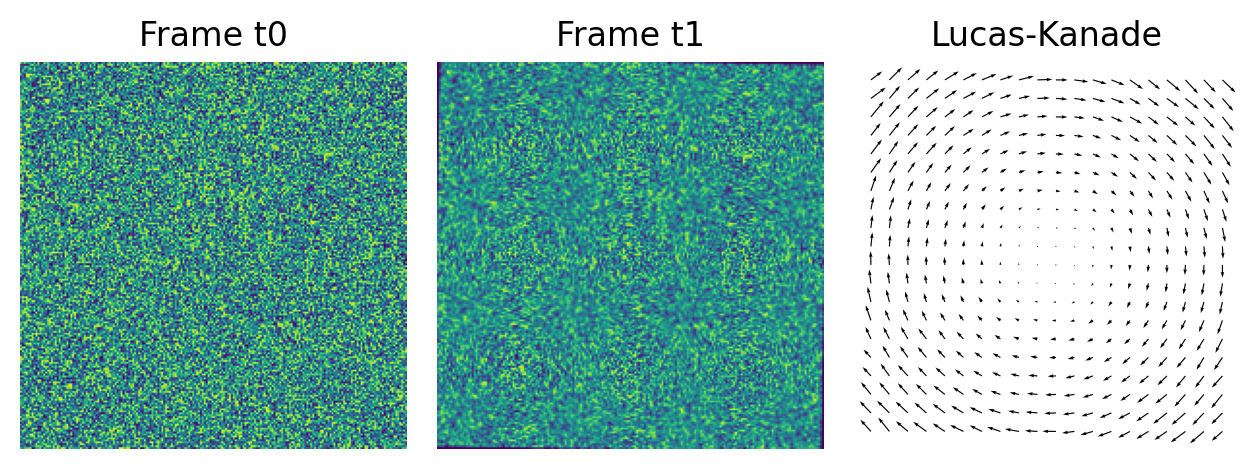

In [5]:
draw_optical_flow(img_t0, img_t1, normalizeImages=False)

可以发现，Lucas-Kanade 算法在运动较小的情况下能够得到较好的效果。接下来让我们看看在运动较大的情况下，Lucas-Kanade 算法的效果如何。

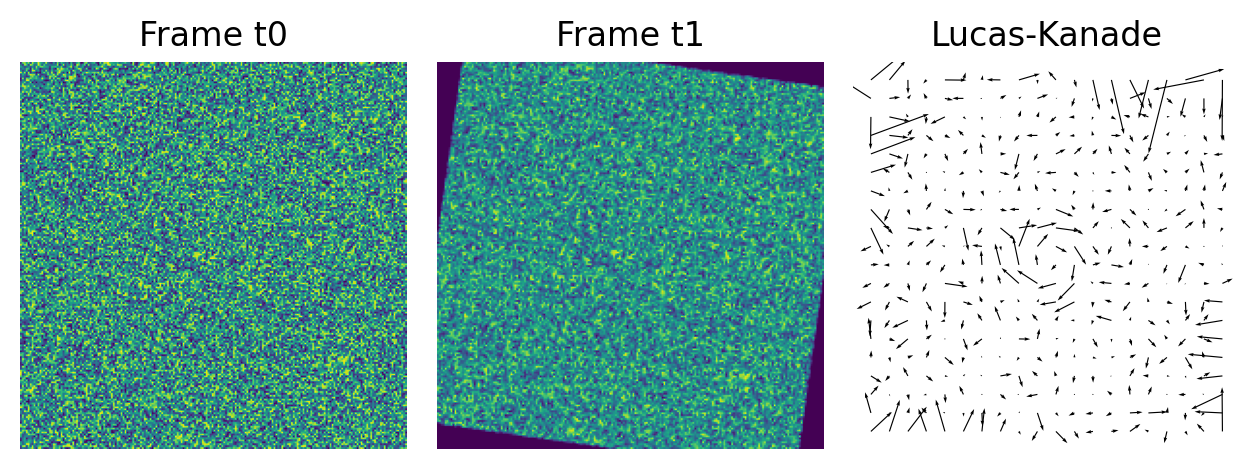

In [6]:
img_t0 = np.random.rand(200, 200).astype(np.float32)
img_t1 = img_t0.copy()

# 测试运动较大的情况（旋转8度）
img_t1 = rotate_image(img_t1, -8) 
draw_optical_flow(img_t0, img_t1, normalizeImages=False)

可以看到当运动幅度较大时，相较于小幅度运动，Lucas-Kanade 算法的效果就不那么理想了。
接下来我们测试在真实的图像上的效果。

In [ ]:
!git clone https://github.com/boyu-ai/Hands-on-CV.git

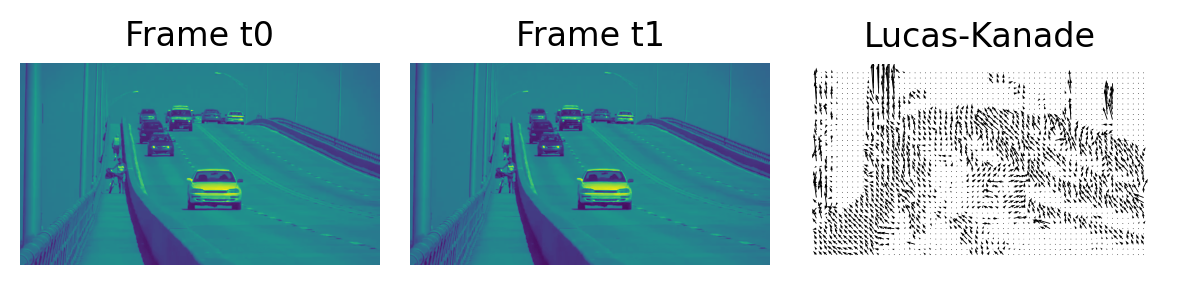

In [ ]:
image_1 = cv2.imread("learncv_img/optical_flow/frame_0001.png", 
                     cv2.IMREAD_GRAYSCALE).astype(np.float32)
image_2 = cv2.imread("learncv_img/optical_flow/frame_0002.png", 
                     cv2.IMREAD_GRAYSCALE).astype(np.float32)
# 绘制出光流图
draw_optical_flow(image_1, image_2, normalizeImages=True, win_size=15)

以上我们实现的是在全部像素上计算光流，在实际的运用过程中，一般是先检测角点，再进行光流的计算，这里我们使用OpenCV的*calcOpticalFlowPyrLK*函数来计算光流。
<!-- # 可视化视频
from IPython.display import display, HTML
# 读者可扫描如下二维码或点击链接
# https://el.ptpress.cn/outLinkPreview?
# id=98d6dc4d-93b6-4635-bde2-337e76cc35ec
# 观看视频
html_str = '''
<video controls src=\"{}\">animation</video>
'''.format("./learncv_img/optical_flow/slow_traffic_small.mp4")
display(HTML(html_str)) -->

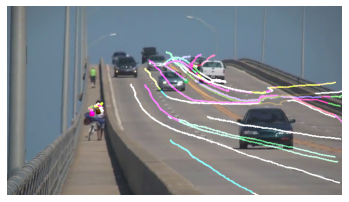

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 读取一段视频用于计算光流
cap = cv.VideoCapture(
    "./learncv_img/optical_flow/slow_traffic_small.mp4")
# ShiTomasi 角点检测参数
feature_params = dict(maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )
# Lucas-Kanade 光流法参数
lk_params = dict( winSize  = (15, 15),
    maxLevel = 2,
    criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 
                10, 0.03))
# 生成随机颜色用于描述光流
color = np.random.randint(0, 255, (100, 3))
# 读取第一帧并找到角点
ret, old_frame = cap.read()
old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
p0 = cv.goodFeaturesToTrack(old_gray, 
                    mask = None, **feature_params)
# 创建一个mask用于绘制轨迹
mask = np.zeros_like(old_frame)
while(1):
    ret, frame = cap.read()
    if not ret:
        print('No frames grabbed!')
        break
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    # 计算光流，并返回光流成功跟踪到的点p1，跟踪状态st以及跟踪差异err
    p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, 
                                          p0, None, **lk_params)
    # 选择好的跟踪点
    if p1 is not None:
        # 筛选出跟踪成功的点
        good_new = p1[st==1]
        good_old = p0[st==1]

    # 绘制轨迹
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv.line(mask, (int(a), int(b)), (int(c), int(d)), \
                       color[i].tolist(), 2)
        frame = cv.circle(frame, (int(a), int(b)), 5, \
                          color[i].tolist(), -1)
        
    img = cv.add(frame, mask)
    # 更新上一帧的图像和跟踪点
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

# 显示结果
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()